# **Aprendizaje Automático para Machine Learning**

##Modelo de sentimientos##

###Andrea Azábal Lamoso y Fabio Santamaría Iglesias###

28 de julio de 2021

---

# Preparación del entorno

Importamos los paquetes necesarios:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import re
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# 1. *Dataset*: *reviews* y *labels*

IMDb (Internet Movie Database) es una base de datos de información de películas. Esta información incluye críticas de películas realizadas por los usuarios de la plataforma. En esta práctica, nos centraremos en analizar el sentimiento (positivo / negativo) de 25.000 *reviews* extraídas de dicha base de datos.

En primer lugar, accedemos a los ficheros que contienen las críticas y sus correspondientes etiquetas:



In [ ]:
!rm -r movie_data
!mkdir movie_data

%cd movie_data/

!wget https://raw.githubusercontent.com/albertojulian/master-ub/main/reviews.txt
!wget https://raw.githubusercontent.com/albertojulian/master-ub/main/labels.txt

%cd ..

/content/movie_data
--2021-07-26 18:59:53--  https://raw.githubusercontent.com/albertojulian/master-ub/main/reviews.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33678267 (32M) [text/plain]
Saving to: ‘reviews.txt’

reviews.txt         100%[===================>]  32.12M   193MB/s    in 0.2s    

2021-07-26 18:59:53 (193 MB/s) - ‘reviews.txt’ saved [33678267/33678267]

--2021-07-26 18:59:53--  https://raw.githubusercontent.com/albertojulian/master-ub/main/labels.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225000 (220K

#2. Preprocesado

A continuación, leemos ambos ficheros y almacenamos la información contenida en cada uno de ellos:

In [ ]:
with open('movie_data/reviews.txt', 'r') as f:
 reviews = f.read()
with open('movie_data/labels.txt', 'r') as f:
 labels = f.read()

Ahora ya estamos listos para realizar todas las transformaciones necesarias en el conjunto de datos antes de comenzar con el entrenamiento de la red neuronal.

## Eliminar mayúsculas

Nos deshacemos de las mayúsculas en las críticas importadas:

In [ ]:
 reviews = reviews.lower()

## Eliminar signos no alfanuméricos

Para que la red sea capaz de procesar correctamente las *reviews*, es necesario quitar cualquier signo de puntuación o carácter no alfanumérico del texto:


In [ ]:
from string import punctuation
print(punctuation)

all_text = ''.join([c for c in reviews if c not in punctuation])

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


En el texto también aparecen saltos de línea o *breaks*, por lo que creamos una función para eliminarlos:

In [ ]:
def remove_breaks(string):
    result = re.sub(' br ','',string)
    return result

In [ ]:
all_text = remove_breaks(all_text)

Así, se tiene el siguiente texto:

In [ ]:
all_text[0:1000]

'bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t   \nstory of a man who has unnatural feelings for a pig  starts out with a opening scene that is a terrific example of absurd comedy  a formal orchestra audience is turned into an insane  violent 

Donde, si nos fijamos, únicamente quedan los caracteres especiales "\n", los cuales denotan el fin de una crítica e inicio de la siguiente. Si separamos las críticas mediante dicho separador, obtenemos 25.000 *reviews*:

In [ ]:
reviews_split = all_text.split('\n')
print ('Number of reviews :', len(reviews_split))

Number of reviews : 25001


El hecho de que en realidad se obtengan 25.001 se debe a que hay un espacio al final:

In [ ]:
reviews_split[25000]

''

Al tratarse de una *review* de longitud 0, nos desharemos de ella más adelante.

## Tokenización

Una de las partes más importantes del preprocesado de texto es la *tokenización* del mismo, la cual consiste en separar el texto en palabras. Además, queremos quedarnos únicamente con las *n* palabras más frecuentes.

Para ello, separamos todas las palabras buscando los espacios, las contamos (gracias a `Counter`) y nos quedamos con las 20.000 más frecuentes en el texto (definimos el parámetro `max_features=20000`).

In [ ]:
from collections import Counter

# Juntamos todas las reviews
all_text2 = ' '.join(reviews_split)
# Separamos por palabra (tokenizacion)
words = all_text2.split()
# Contamos las palabras
count_words = Counter(words)
# Palabras más frecuentes
total_words = max_features = 20000 # Lo usaremos en todos los modelos
# Ordenamos de más a menos frecuente
sorted_words = count_words.most_common(total_words)

Así, por ejemplo, si elegimos las 10 palabras más frecuentes, se tiene:



In [ ]:
n = 10
count_words.most_common(n)

[('the', 336713),
 ('and', 164107),
 ('a', 163009),
 ('of', 145864),
 ('to', 135720),
 ('is', 107328),
 ('it', 96352),
 ('in', 93968),
 ('i', 87623),
 ('this', 76000)]

## Asignar identificadores a cada palabra

A continuación, procedemos a asignar un identificador unívoco a cada palabra del texto.

Así, primero asignamos un número a las 20.000 palabras más frecuentes, las cuales ya habíamos ordenado de más a menos repetidas en las *reviews*. Además, reservamos el número 0 para el *padding*, por lo que de esta forma la palabra "*the*" tendrá el identificador 1, "*and*" el identificador 2, etc.

In [ ]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

Para las palabras que no están entre las más frecuentes, asignamos un 0.  Por consiguiente, en la primera *review* vemos que la primera palabra está siendo identificada como 0, es decir, es una palabra poco frecuente. Si nos fijamos, la primera palabra de la primera crítica es "*Bromwell*", un nombre propio, por lo que tiene sentido que no sea un vocablo común en el corpus.

In [ ]:
reviews_int = []
for review in reviews_split:
    r = [vocab_to_int[w] if w in vocab_to_int else 0 for w in review.split()]
    reviews_int.append(r)
print(reviews_int[0:1])

[[0, 307, 6, 3, 1049, 206, 7, 2137, 31, 1, 170, 56, 14, 48, 80, 5784, 43, 381, 109, 139, 14, 5193, 59, 153, 8, 1, 4974, 5851, 474, 70, 5, 259, 11, 0, 307, 12, 1977, 6, 73, 2394, 5, 612, 72, 6, 5193, 1, 0, 5, 1982, 10165, 1, 5785, 1498, 35, 50, 65, 203, 144, 66, 1198, 5193, 19868, 1, 0, 4, 1, 220, 882, 30, 2987, 70, 4, 1, 5786, 9, 685, 2, 66, 1498, 53, 9, 215, 1, 382, 8, 61, 3, 1405, 3685, 782, 5, 3482, 179, 1, 381, 9, 1211, 13582, 31, 307, 3, 348, 340, 2912, 9, 142, 126, 5, 7689, 29, 4, 128, 5193, 1405, 2325, 5, 0, 307, 9, 527, 11, 108, 1447, 4, 59, 542, 101, 11, 0, 307, 6, 226, 4145, 47, 3, 2210, 11, 7, 214, 22]]


Por otra parte, también es necesario identificar las etiquetas. En primer lugar las separamos y a continuación consideramos "*negative*" como 0 y "*positive*" como 1.

In [ ]:
labels_split = labels.split('\n')

encoded_labels = [1 if label =='positive' else 0 for label in labels_split]
encoded_labels = np.array(encoded_labels)

print(labels_split[1:10])
print(encoded_labels[1:10])

['negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative']
[0 1 0 1 0 1 0 1 0]


Podemos comprobar que se trata de un *dataset* balanceado, pues al sumar todas las críticas obtenemos 12.500:

In [ ]:
encoded_labels.sum()

12500

Es decir, el 50% de las críticas son positivas y el 50% restante negativas.

Por último, nos deshacemos de las *reviews* y *labels* que tienen longitud igual a 0:

In [ ]:
reviews_len = [len(x) for x in reviews_int]

reviews_int = [ reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_labels = [ encoded_labels[i] for i, l in enumerate(reviews_len) if l> 0 ]

Comprobamos que nos hemos quedado con 25.000 opiniones y, por tanto, hemos eliminado únicamente una crítica, que era la que ya teníamos localizada previamente:

In [ ]:
len(reviews_int)

25000

## Truncar o rellenar *reviews*

De cara a la modelización, queremos que todas nuestras *reviews* tengan la misma longitud: 160 palabras. Para ello, definimos una función que devuelve las primeras 160 palabras de la *review* si esta es más larga o rellena con 0 las *reviews* que tienen longitudes inferiores. El relleno se introduce al principio de cada *review* debido a que, en una red neuronal recurrente, se tiende a dar más relevancia al final de la secuencia de entrada, aunque en el tipo de red que vamos a emplear (*LSTM*) no se tiene este problema.


In [ ]:
def pad_features(reviews_int, seq_length):
    
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

Comprobamos que, efectivamente, se han rellenado con 0 las críticas más cortas:

In [ ]:
features = pad_features(reviews_int, 160)

print(features)

[[   0    0    0 ...    7  214   22]
 [   0    0    0 ...   28  107 3323]
 [   0   41    0 ...  175  362 6892]
 ...
 [  48  106   11 ...   36   75   24]
 [ 761  690  710 ...  630  274    2]
 [   0    0    0 ...   10    6 1320]]


## Generar *datasets* de entrenamiento, validación y pruebas 


Como último paso antes de la implementación de la red neuronal, vamos a dividir el conjunto de datos original en 80% para entrenamiento, 10% para validación y 10% para pruebas.

In [ ]:
split_frac = 0.8
len_feat = len(reviews_int)

# Entrenamiento
train_x = features[0:int(split_frac*len_feat)]
train_y = encoded_labels[0:int(split_frac*len_feat)]
remaining_x = features[int(split_frac*len_feat):]
remaining_y = encoded_labels[int(split_frac*len_feat):]

# Validación
valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]

# Test
test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]

Procedemos a generar el `DataLoader` con un tamaño del *batch* de 100 *reviews*.

In [ ]:
batch_size = 100

train_data = TensorDataset(torch.from_numpy(np.array(train_x)), torch.from_numpy(np.array(train_y)))
valid_data = TensorDataset(torch.from_numpy(np.array(valid_x)), torch.from_numpy(np.array(valid_y)))
test_data = TensorDataset(torch.from_numpy(np.array(test_x)), torch.from_numpy(np.array(test_y)))

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

#3. Carga de palabras vectorizadas *GloVe*

Con el objetivo de utilizar unos *embeddings* previamente generados, vamos a importar el fichero *GloVe*, el cual contiene 400.000 palabras vectorizadas en vectores de dimensión 100.

Lo primero es crear una conexión de *Google Drive* a *Google Colab* e importar el fichero de *GloVe* que previamente habíamos descargado del aula virtual:

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Después transformamos el archivo *.txt* a formato *word2vec*:

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = "/content/drive/MyDrive/Colab Notebooks/Módulo 7/glove.6B.100d.txt" #Andrea
#glove_input_file = "/content/drive/MyDrive/MasterUB/Modulo 7/glove.6B.100d.txt" #Fabio
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

A continuación, usamos la función *load_word2vec_format* para cargar el modelo de *embeddings*: 


In [ ]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
embedding_model = KeyedVectors.load_word2vec_format(filename, binary=False)

Nuestro modelo contiene 400.000 palabras expresadas como vectores de 100 dimensiones:

In [ ]:
embedding_size = 100
vocab = set(embedding_model.vocab)

Acto seguido construimos la matriz de *embeddings* a partir del vocabulario extraído de nuestro *dataset*. Recordemos que previamente hemos tokenizado cada *review*, quedándonos con las 20.000 palabras más frecuentes y asignando 0 al resto. 

Así, esta matriz contendrá tantas filas como *tokens*, es decir, 20.000 correspondientes a las palabras de nuestro vocabulario y una a mayores reservada al resto de palabras poco frecuentes (0), por tanto, un total de 20.001 filas. El número de columnas se corresponderá con la dimensión del modelo de *embedding*: 

In [ ]:
# creamos la matriz de embeddings pre-entrenados

def create_pretrained_embedding_matrix(num_words, embedding_size, vocab_to_int, embedding_model, vocab):
    embedding_matrix = np.zeros((num_words, embedding_size))
    print(embedding_matrix.shape)
    for word, i in vocab_to_int.items():
        if word in vocab: # las palabras que no estén en el modelo de embeddings, estarán formadas inicialmente por embeddings con ceros. 
           embedding_matrix[i] = embedding_model[word] #i = 0 será una fila llena de 0s que se corresponderá con el valor padding = 0 que hemos usado para representar las palabras que no hemos tokenizado.
    return embedding_matrix

import torch

embedding_matrix = create_pretrained_embedding_matrix(max_features + 1, embedding_size, vocab_to_int, embedding_model, vocab) 
embedding_matrix = torch.from_numpy(embedding_matrix) # torch.float64


(20001, 100)


De esta forma, hemos conseguido identificar unívocamente cada una de las 20.000 palabras más frecuentes con un vector de 100 componentes, todo ello representado en una matriz. Hemos dejado la primera fila de esta matriz como un vector de ceros, ya que su posición se corresponde con el *token* comodín que usamos para palabras fuera de nuestro vocabulario. La siguiente fila, la fila con índice 1, la ocupará la palabra más frecuente de nuestro corpus ("the") y así sucesivamente hasta completar todas las filas.

Usando esta representación matricial estamos partiendo de un conocimiento básico del lenguaje, pues las diferencias tanto en el ámbito léxico como en el  significado entre las palabras estarán mejor representadas en las distancias de estos vectores que en nuestra *tokenización* previa. Así, si ciertas palabras están relacionadas entre sí, es de esperar que la diferencia entre los vectores sea menor, y viceversa. Incluso es posible definir cierto álgebra entre palabras, tal y como vimos en la teoría donde "king - man + woman = queen". 

Es de esperar que los resultados mejoren usando este tipo de representación del texto. Aplicaremos este modelo de *embeddings* a uno de los nuestros modelos *LSTM* para ver cómo efectivamente se produce una mejora significativa en la precisión de la red.  

#4. Red Neuronal Recurrente *LSTM*

En esta sección construiremos un modelo *LSTM* sencillo que nos servirá de *baseline*. En los sucesivos apartados le iremos añadiendo más complejidad. Como vamos a comparar varios modelos, refactorizamos las funciones más usadas:

- `get_gpu()`: comprueba si hay alguna GPU disponible.
- `train_model()`: entrena el modelo.
- `test_model()`: devuelve las predicciones del modelo.
- `plot_results()`: permite representar cómo evoluciona la función de pérdida y la precisión durante el entrenamiento.
- `print_metrics()`: devuelve la matriz de confusión y el *classification report*.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


def get_gpu():
    '''
    Comprueba si hay alguna GPU disponible. 
    Si es así, devuelve train_on_gpu = True y device = el nombre del dispostivo en 
    '''

    train_on_gpu = torch.cuda.is_available()

    if(train_on_gpu):
        device = torch.device('cuda')
        print('Training on GPU.')
    else:
        device = torch.device('cpu')
        print('No GPU available, training on CPU.')

    return train_on_gpu, device

def train_model(model, criterion, optimizer, train_loader, valid_loader, 
                train_on_gpu = False, epochs = 15, counter = 0, clip = 5):
    '''
    Entrena el modelo. 
    Devuelve el objeto history que contiene: loss, val_loss, accucracy y val_accururacy
    '''

    # mover modelo a la GPU, si está disponible
    if(train_on_gpu):
        model.cuda()

    history = {"loss":[], "val_loss":[], "acc":[], "val_accuracy":[], "accuracy":[]}

    model.train()
    # entrenar X epoch
    for e in range(epochs):
        
        num_correct_train = 0
        # batch loop
        for inputs, labels in train_loader:
            counter += 1

            if(train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()

            # zero accumulated gradients
            model.zero_grad()

            # output del modelo
            output = model(inputs)

            # loss function y backpropagation
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            # `clip_grad_norm` ayuda a prevenir el 'exploding gradient'
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            # predicciones y metricas
            pred = torch.round(output.squeeze())
            correct_tensor = pred.eq(labels.float().view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            num_correct_train += np.sum(correct)

        acc = 100*num_correct_train/len(train_loader.dataset)

        # evaluacion
        val_losses = []
        model.eval()
        num_correct = 0
        for inputs, labels in valid_loader:

            if(train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()

            output = model(inputs)
            val_loss = criterion(output.squeeze(), labels.float())
            val_losses.append(val_loss.item())

            # convierte la probabilidad en una clase (0 o 1)
            pred = torch.round(output.squeeze())  # redondeo

            # predicciones
            correct_tensor = pred.eq(labels.float().view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            num_correct += np.sum(correct)

        val_loss_mean = np.mean(val_losses)
        val_acc = 100*num_correct/len(valid_loader.dataset)

        model.train()
        print(f"Epoch: {e+1}/{epochs}...Step: {counter}...",
              f"Loss: {loss.item():.4f}...",
              f"Val Loss: {val_loss_mean:.4f}",
              f"Acc: {acc:.1f}%",
              f"Val Acc: {val_acc:.1f}%")
        
        history['loss'].append(loss.item())
        history['val_loss'].append(val_loss_mean)
        history['val_accuracy'].append(val_acc)
        history['accuracy'].append(acc)

    return history


def test_model(model, test_loader, train_on_gpu = False):
    '''
      Devuelve las predicciones del modelo.
    '''

    test_losses = [] 
    y_pred = []
    y_labels = []

    if (train_on_gpu):
        model.cuda()

    model.eval()
    # iteracion sobre testing
    for inputs, labels in test_loader:

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        
        # output
        output = model(inputs)
        
        # loss function
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())
        
        # convertir predicciones en clases (0 o 1)
        pred = torch.round(output.squeeze())  # redondeo
        y_pred.extend(pred.detach().numpy() if not train_on_gpu else pred.cpu().detach().numpy())
        y_labels.extend(labels.detach().numpy() if not train_on_gpu else labels.cpu().detach().numpy())
    
    print("Test loss: {:.3f}".format(np.mean(test_losses)))
    return y_labels, y_pred



def plot_results(history):
    '''
    Permite representar cómo evoluciona la función de pérdida y la precisión
    '''
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title('Pérdida en función de epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()
    plt.close()
    plt.plot(history['accuracy'], label='accuracy')
    plt.plot(history['val_accuracy'], label='val_accuracy')
    plt.title('Precisión en función de epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.close()


def print_metrics(y_labels, y_pred):
    '''
    Permite desagregar los errores cometidos por el modelo según la clase: 
    Recall, precision, f1-score y matriz de confusión
    '''
    print("Classification Report:")
    classification_report_values = classification_report(y_labels, y_pred)
    print(classification_report_values)
    print("Confusion Matrix:")
    confusion_matrix_values = confusion_matrix(y_labels, y_pred)
    df_cm = pd.DataFrame(confusion_matrix_values)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt="d", cmap="YlGnBu",
               xticklabels=('Pred 0','Pred 1'),yticklabels=('Real 0','Real 1'))

## Modelo sencillo (modelo *baseline*)

La *Long Short-Term Memory* (*LSTM*) es una arquitectura de red neuronal recurrente (RNN) utilizada en el campo del aprendizaje profundo (*Deep Learning*). A diferencia de las redes neuronales de prealimentación (*feedforward neural networks*) estándar, las *LSTM* tienen conexiones de retroalimentación (*feedback connections*). Esto les permite no solo procesar puntos de datos individuales (como imágenes), sino también secuencias completas de datos (como voz o vídeo). Por ejemplo, las *LSTM* son aplicables a tareas como el reconocimiento de escritura a mano conectada y no segmentada, reconocimiento de voz y detección de anomalías en el tráfico de red o IDS (sistemas de detección de intrusos). 





La arquitectura básica de una red recurrente se dispone de la siguiente manera:

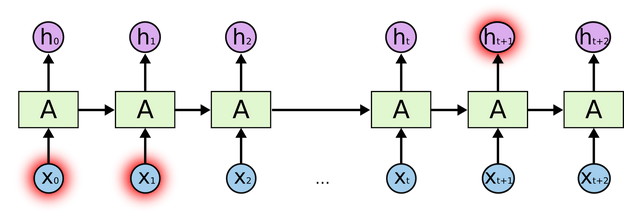


Donde la caja A es la primera capa de la red en su totalidad, que se representa repetida de izquierda a derecha en diferentes momentos temporales. $x_t$ y $h_t$ son  respectivamente los inputs y las predicciones (en modelos de una sola capa) del modelo para un tiempo $t$.
Como vemos en la imagen, el estado oculto viaja de izquierda a derecha, convirtiéndose en una entrada y salida del modelo, pasando la información del estado inmediatamente anterior al siguiente.


La particularidad de las LSTM reside en usar un modelo mucho más complejo y que contiene un estado oculto:

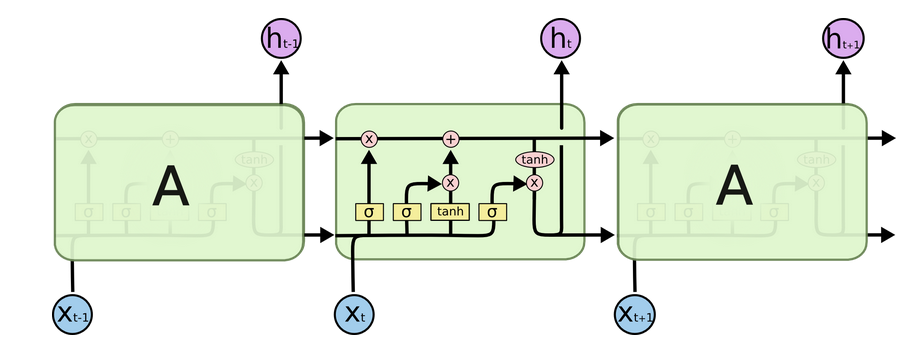

Fuente de la imagen: [colah.github.io](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

Una unidad LSTM común se compone de una celda, en la que hay una puerta de entrada (input gate), una puerta de salida (output gate) y una puerta de olvido (forget gate). La celda recuerda valores en intervalos de tiempo arbitrarios y las tres puertas regulan el flujo de información dentro y fuera de la celda.

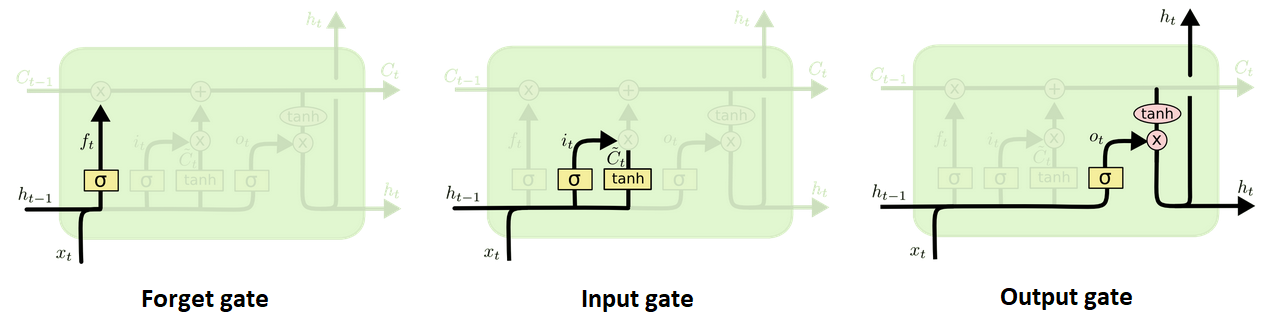

Fuente de la imagen: [colah.github.io](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

Más en detalle, como podemos ver en la figura, las tres puertas interactúan con una entrada $C(i-1)$ que cruza por la parte vertical de lado a lado. A esta entrada se le denomina *cell state*, y básicamente es como una cinta transportadora que lleva la información a lo largo de la red LSTM, cruzando toda su cascada de bloques.
Las tres puertas, haciendo uso de sus activaciones sigmoides y tangenciales, y en combinación con los pesos que se incluyen en cada una, permiten determinar la salida $h(i)$ de cada bloque de la LSTM de modo que la información importante para ese punto $i$ de la secuencia haya sido seleccionada. Gracias al uso de $C$ y las tres puertas, el cálculo del gradiente se simplifica incluso entre puntos alejados.

Las *LSTM* modificaron la arquitectura original de las RNN para mejorar la capacidad de la red neuronal "de recordar" y así poder trabajar con secuencias de dependencias más largas, como las que pueda haber en un texto. Son adecuadas para clasificar, procesar y hacer predicciones basadas en datos de series temporales, ya que puede haber retrasos de duración desconocida entre eventos importantes en una serie de este tipo. Se desarrollaron para hacer frente al problema de anulación del gradiente (*vanishing gradient problem*) que puede darse al entrenar a las RNN tradicionales. 

Así, lo primero es definir una capa de embeddings que traduzca cada palabra *tokenizada* de nuestro limitado diccionario a un vector de 100 componentes. No obstante, no usaremos de momento la matriz de *embeddings* obtenida con el fichero de *GloVe* en el paso anterior, sino que se [inicializarán los vectores de forma aleatoria siguiendo una distribución N(0,1)](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html). 

Alimentaremos de esta manera a nuestro modelo *baseline*, el cual se compondrá inicialmente de una red *LSTM* simple monocapa seguida de una capa densa totalmente conectada. La función de activación final será la Sigmoid estándar, pues únicamente se tienen dos clases posibles: positiva (1) y negativa (0).

De esta manera, las dimensiones a tener en cuenta son:

* max_features: tamaño de nuestro vocabulario. Como ya hemos dicho, 20.000 palabras diferentes.

* vocabulary_size: tamaño de nuestro vocabulario teniendo en cuenta el valor *padding* donde se agrupan el resto de palabras no contenidas en el vocabulario, por tanto, 20.001.

* embedding_size: dimensión de los vectores que representan cada palabra, 100.

* hidden_dim: dimensión del estado oculto que hay entre la capa *LSTM* y la capa lineal densa. Hemos seleccionado también 100.

* output_dim: dimensión de salida. Al ser un problema de clasificación binaria y usar una función de activación Sigmoid estándar su valor es 1.


Por último, definimos:

* un learning rate de 0.001. 

* la función de coste [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) que mide la Entropía cruzada binaria (Binary Cross Entropy) entre el *target* y el *output*.

* el optimizador tipo [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam).

* Opcionalmente nos valemos de nuestra función *get_gpu()* para, siempre y cuando sea posible, usar una GPU con la finalidad de acelerar por *hardware* el entrenamiento y la validación del modelo.



In [ ]:
# definimos clase para el modelo de LSTMs en pytorch

import torch.nn as nn

hidden_dim = embedding_size = 100
output_dim = 1 # si fueran datos categóricos (necesario cuando hay más de 2 clases), aquí iría el nº de clases


class LSTM(nn.Module):
  def __init__(self, vocabulary_size, embedding_size, hidden_dim,
               output_dim, device):
    super().__init__()

    self.output_size = output_dim
    self.hidden_dim = hidden_dim
    self.device = device

    self.embedding = nn.Embedding(vocabulary_size, embedding_size)

    self.lstm = nn.LSTM(embedding_size, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sig = nn.Sigmoid()

  def forward(self, x):
  
    x = self.embedding(x)

    x = x.float()

    lstm_out, hidden = self.lstm(x)
    lstm_out = lstm_out[:, -1, :]

    out = self.fc(lstm_out)
    sig_out = self.sig(out)
    return sig_out


train_on_gpu, device = get_gpu()

# creamos el modelo de LSTM
model_simple = LSTM(max_features + 1, embedding_size, hidden_dim, #20.000 palabras + padding=0 para palabras sin tokenizar
               output_dim, device=device)

# definimos learning rate, loss function y optimizer
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_simple.parameters(), lr=lr)

print(model_simple)

Training on GPU.
LSTM(
  (embedding): Embedding(20001, 100)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (sig): Sigmoid()
)


Una vez definida la red neuronal LSTM, procedemos a entrenarla durante 15 *epochs*:

In [ ]:
history_model_simple = train_model(model_simple, criterion, optimizer, train_loader, valid_loader, train_on_gpu, 15)

Epoch: 1/15...Step: 200... Loss: 0.6304... Val Loss: 0.6199 Acc: 58.7% Val Acc: 66.2%
Epoch: 2/15...Step: 400... Loss: 0.5563... Val Loss: 0.5604 Acc: 71.4% Val Acc: 72.6%
Epoch: 3/15...Step: 600... Loss: 0.5386... Val Loss: 0.5170 Acc: 77.2% Val Acc: 76.0%
Epoch: 4/15...Step: 800... Loss: 0.3401... Val Loss: 0.4808 Acc: 82.2% Val Acc: 79.0%
Epoch: 5/15...Step: 1000... Loss: 0.3573... Val Loss: 0.4856 Acc: 86.0% Val Acc: 78.8%
Epoch: 6/15...Step: 1200... Loss: 0.2989... Val Loss: 0.5156 Acc: 89.0% Val Acc: 80.1%
Epoch: 7/15...Step: 1400... Loss: 0.1351... Val Loss: 0.5330 Acc: 91.8% Val Acc: 80.2%
Epoch: 8/15...Step: 1600... Loss: 0.1585... Val Loss: 0.5519 Acc: 93.1% Val Acc: 79.7%
Epoch: 9/15...Step: 1800... Loss: 0.1602... Val Loss: 0.6837 Acc: 94.8% Val Acc: 78.8%
Epoch: 10/15...Step: 2000... Loss: 0.0675... Val Loss: 0.6293 Acc: 95.9% Val Acc: 79.7%
Epoch: 11/15...Step: 2200... Loss: 0.1642... Val Loss: 0.7038 Acc: 96.4% Val Acc: 79.9%
Epoch: 12/15...Step: 2400... Loss: 0.1250... 

Comprobamos que, a medida que avanza el número de iteraciones sobre el *dataset* de entrenamiento, la función de pérdida disminuye y la precisión aumenta hasta alcanzar casi un 99% en la última *epoch*. 

Por otra parte, el comportamiento sobre el subconjunto de validación es distinto, como se puede observar en las siguientes representaciones gráficas:

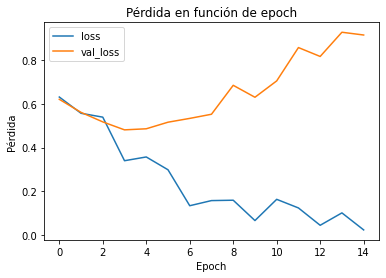

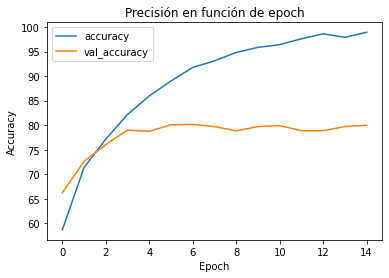

In [ ]:
plot_results(history_model_simple)

En la primera gráfica se observa cómo las funciones de pérdida sobre ambos *datasets* comienzan en un punto similar, pero tras un par de iteraciones divergen de manera que la *loss function* sobre el subconjunto de validación alcanza un mínimo en torno a 4-6 *epochs*, a partir del cual comienza a aumentar.

Por otra parte, si nos fijamos en la gráfica de la precisión, comprobamos que la *accuracy* sobre el subconjunto de entrenamiento aumenta hasta casi un 100% al finalizar el entrenamiento. 

Para el subconjunto de evaluación, sin embargo, se tiene una tendencia ascendente hasta la cuarta iteración, es decir, está claro que con pocas iteraciones la red todavía no ha aprendido lo suficiente y estamos ante la presencia de *underfitting*. A partir de la cuarta *epoch*, comienza a verse un comportamiento oscilatorio en torno a un 78% de precisión, por lo que para *epochs* lo suficientemente avanzadas existe *overfitting* y el modelo no es capaz de generalizar sobre nuevos conjuntos de datos.

Si lo trasladamos a nuestro *dataset* en particular, el resultado que estamos obteniendo significa que somos capaces de analizar correctamente el sentimiento (positivo o negativo) en todas las críticas que hemos utilizado para entrenar la red, mientras que este sentimiento solo se acierta en el 78% de nuevas críticas que apliquemos al algoritmo. 

Este resultado no es del todo malo teniendo en cuenta que, como ya habíamos corroborado, el conjunto de datos es balanceado por lo que tenemos un 50% de críticas positivas y un 50% de críticas negativas. Si la red predijese siempre 0 o siempre 1, estaríamos acertando únicamente el 50% de las predicciones, por lo que un 78% de precisión implica que la red neuronal que hemos entrenado es capaz de extraer el sentimiento de cada *review* hasta cierto punto.

A continuación, aplicamos la función previamente definida `test_model` sobre el modelo que hemos creado, pero esta vez para el subconjunto de *test*: 



In [ ]:
y_labels, y_pred_model_simple = test_model(model_simple, test_loader, train_on_gpu)

Test loss: 0.970


Con los resultados extraídos de dicha función, podemos representar la matriz de confusión y el `classification report` para ver cómo se está clasificando cada categoría:

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1250
           1       0.78      0.80      0.79      1250

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500

Confusion Matrix:


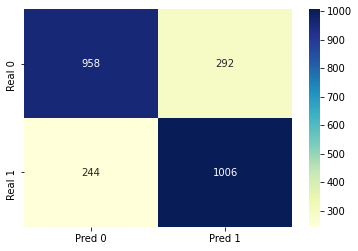

In [ ]:
print_metrics(y_labels, y_pred_model_simple)

Así, comprobamos que ambas clases se comportan de manera muy similar, habiendo una cantidad ligeramente superior de verdaderos positivos en la clase 1, es decir, en críticas positivas. 

Podemos, por ejemplo, calcular los valores del *precision* y *recall* de la clase 1:

$$ Precision_1 =  \frac{TP}{TP+FP} = \frac{1006}{1006+292}=0.775$$ 

$$ Recall_1 =  \frac{TP}{TP+FN}=\frac{1006}{1006+244}=0.805$$ 

La precisión global viene dada por:

$$ Precision_\text{total} =  \frac{TP}{TP+FN} = \frac{1006+958}{1006+958+292+244}=0.786$$ 

En resumen, la red neuronal recurrente implementada tiene una precisión del 79% sobre el subconjunto de *testing* generado.

# 5. Mejoras en la red

A lo largo de este apartado vamos a intentar mejorar los resultados obtenidos en el apartado anterior, aplicando las siguientes modificaciones sobre el modelo *baseline* definido:

- Añadir otro nivel a la red LSTM (parámetro n_layers).
- Añadir bidireccionalidad.
- Añadir capas de dropout.
- Añadir otro nivel lineal.
- Sustituir los pesos de la capa de *embeddings* por los del fichero *GloVe*.

El objetivo será conseguir una precisión global superior al 80% sobre el subconjunto de *test*.

## Añadir segundo nivel *LSTM*

El primer cambio que vamos a aplicar sobre la red es la adición de una segunda capa *LSTM*, de manera que el *input* de la segunda capa será mucho más complejo. De esta forma, añadimos profundidad al modelo con la intención de ser capaces de mejorar la capacidad de aprendizaje de la red.


In [ ]:
# definimos clase para el modelo de LSTMs en pytorch

import torch.nn as nn

hidden_dim = embedding_size = 100
output_dim = 1 # si fueran datos categóricos (necesario cuando hay más de 2 clases), aquí iría el nº de clases
num_layers = 2 # NUEVA CAPA LSTM

class LSTM(nn.Module):
  def __init__(self, vocabulary_size, embedding_size, hidden_dim,
               output_dim, num_layers, device):
    super().__init__()

    self.output_size = output_dim
    self.hidden_dim = hidden_dim
    self.device = device

    self.embedding = nn.Embedding(vocabulary_size, embedding_size)

    self.lstm = nn.LSTM(embedding_size, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sig = nn.Sigmoid()

  def forward(self, x):
    
    x = self.embedding(x)

    x = x.float()

    lstm_out, hidden = self.lstm(x)
    lstm_out = lstm_out[:, -1, :]

    out = self.fc(lstm_out)
    sig_out = self.sig(out)
    return sig_out


train_on_gpu, device = get_gpu()

# creamos el modelo de LSTM
model_2_layers = LSTM(max_features + 1, embedding_size, hidden_dim,
               output_dim, num_layers, device=device)

# definimos learning rate, loss function y optimizer
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_2_layers.parameters(), lr=lr)

print(model_2_layers)

Training on GPU.
LSTM(
  (embedding): Embedding(20001, 100)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (sig): Sigmoid()
)


Procedemos a entrenar durante 15 iteraciones el nuevo modelo, de manera que se obtienen los siguientes resultados por *epoch*:

In [ ]:
history_model_2_layers = train_model(model_2_layers, criterion, optimizer, train_loader, valid_loader, train_on_gpu, 15)

Epoch: 1/15...Step: 200... Loss: 0.5632... Val Loss: 0.6057 Acc: 60.8% Val Acc: 70.2%
Epoch: 2/15...Step: 400... Loss: 0.5411... Val Loss: 0.5827 Acc: 65.5% Val Acc: 70.8%
Epoch: 3/15...Step: 600... Loss: 0.5494... Val Loss: 0.5427 Acc: 77.2% Val Acc: 73.4%
Epoch: 4/15...Step: 800... Loss: 0.3986... Val Loss: 0.4880 Acc: 82.8% Val Acc: 78.0%
Epoch: 5/15...Step: 1000... Loss: 0.3180... Val Loss: 0.4673 Acc: 85.7% Val Acc: 78.8%
Epoch: 6/15...Step: 1200... Loss: 0.3501... Val Loss: 0.4842 Acc: 89.2% Val Acc: 80.3%
Epoch: 7/15...Step: 1400... Loss: 0.2119... Val Loss: 0.4776 Acc: 90.9% Val Acc: 81.4%
Epoch: 8/15...Step: 1600... Loss: 0.2081... Val Loss: 0.5017 Acc: 93.3% Val Acc: 80.8%
Epoch: 9/15...Step: 1800... Loss: 0.1850... Val Loss: 0.5728 Acc: 94.8% Val Acc: 80.4%
Epoch: 10/15...Step: 2000... Loss: 0.1011... Val Loss: 0.6444 Acc: 95.8% Val Acc: 79.1%
Epoch: 11/15...Step: 2200... Loss: 0.1001... Val Loss: 0.6458 Acc: 97.0% Val Acc: 80.5%
Epoch: 12/15...Step: 2400... Loss: 0.0974... 

Vemos cómo, una vez más, la función de pérdida disminuye a medida que avanzan las *epochs*, mientras que sucede lo contrario para la *accuracy* sobre el *set* de entrenamiento.

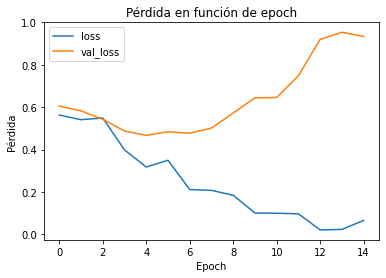

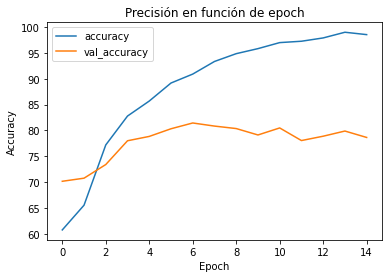

In [ ]:
plot_results(history_model_2_layers)

En las gráficas podemos observar un comportamiento muy similar al ya expuesto en el primer modelo (*baseline*). Así, se tiene un mínimo para la función de pérdida sobre el *dataset* de evaluación en torno a 7 *epochs*. 

Por su parte, la precisión sobre el *dataset* de evaluación es superior a la precisión sobre el *dataset* de entrenamiento para iteraciones tempranas. Esto se debe a que la precisión se calcula una vez finalizado el entrenamiento de una determinada *epoch*, por lo que los pesos están mejor ajustados durante la evaluación que durante el entrenamiento. Aun así, en ambos casos la precisión es muy baja, por lo que en esta etapa tan temprana del entrenamiento tenemos *underfitting*. Al aumentar las iteraciones, se alcanza un máximo en torno a 7 *epochs*, y posteriormente vemos cómo adquiere un comportamiento oscilatorio, reflejo del *overfitting* o sobreajuste de la red neuronal al subconjunto de entrenamiento.

Procedemos ahora a recuperar las predicciones al aplicar el algoritmo sobre el subconjunto de *testing*:

In [ ]:
y_labels, y_pred_model_2_layers = test_model(model_2_layers, test_loader, train_on_gpu)

Test loss: 0.918


Si representamos la matriz de confusión y el *classification report*:

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      1250
           1       0.83      0.75      0.79      1250

    accuracy                           0.80      2500
   macro avg       0.80      0.80      0.80      2500
weighted avg       0.80      0.80      0.80      2500

Confusion Matrix:


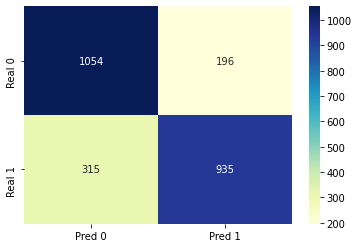

In [ ]:
print_metrics(y_labels, y_pred_model_2_layers)

Comprobamos que la precisión global ha aumentado muy levemente respecto al *baseline*:

$$ Precision_\text{total} =  \frac{TP}{TP+FN} = \frac{1054+935}{1054+935+196+315}=0.796$$ 

En concreto, hemos aumentado la precisión global en un 1% respecto al modelo anterior. Además, si nos fijamos en la matriz de confusión, vemos que en esta ocasión se están clasificando ligeramente mejor las críticas negativas. Destaca a su vez el bajo *recall* de las críticas positivas (75%), lo cual implica que muchas de estas críticas están siendo catalogadas como negativas.

Cabía esperar una mejora en la precisión global del modelo pues hemos introducido una segunda capa *LSTM* que incrementa la capacidad de aprendizaje de la red neuronal, aunque lo que hemos obtenido no puede considerarse una mejora significativa. Habría que replantearse, por tanto, la decisión de añadir esta segunda capa *LSTM* y ver si realmente compensa el esfuerzo extra a la hora de entrenar el algoritmo.

## Añadir bidireccionalidad

El siguiente paso en busca de mejorar la precisión global de la red neuronal es la adición de bidireccionalidad a los cambios ya realizados previamente sobre el *baseline*.

El objetivo de implementar la bidireccionalidad es mejorar el rendimiento de la red *LSTM* aprovechando para ello al máximo el *input*. Vamos a duplicar el número de capas que componen nuestra red *LSTM* (previamente tenía 2) de forma que las dos primeras capas lean la secuencia de palabras de entrada, una de ellas al derecho (*forward*) y otra de ellas al revés (*backward*). A partir de aquí podemos hacer dos cosas. O bien usamos cada estado oculto que ha generado cada capa para alimentar las siguientes o bien combinamos su salida:


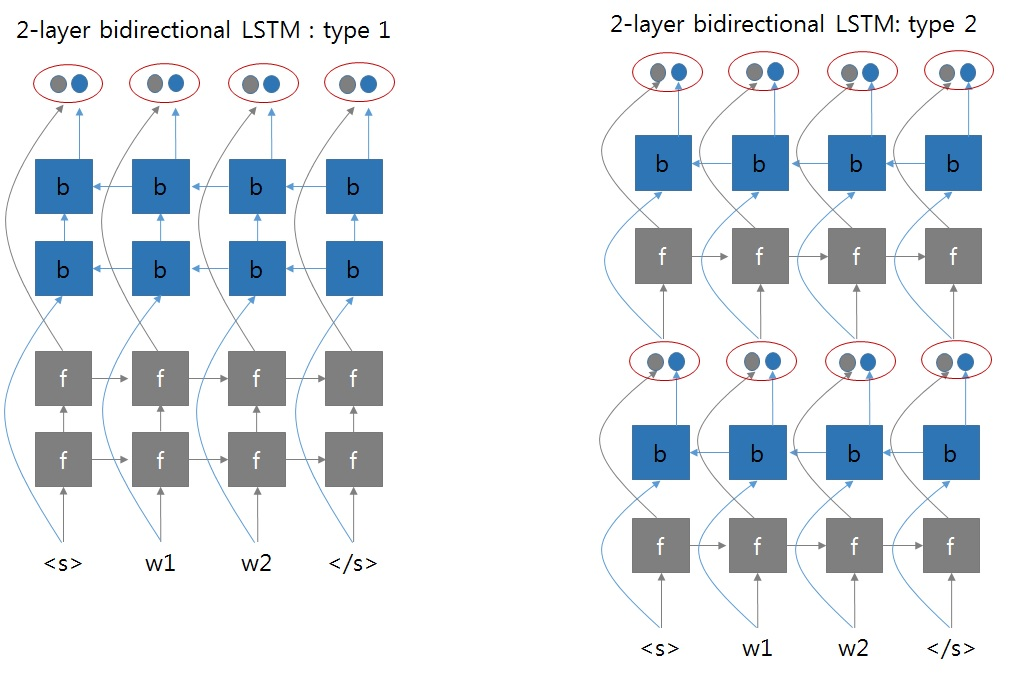

Si nos vamos a la documentación que ofrece Pytorch sobre [la implementación de la bidireccionalidad en redes LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html), concluimos que nuestra arquitectura es de tipo II. Es decir, la salida de estas dos primeras capas se combinará en un estado oculto que alimentará al siguiente par de capas.

Por otro lado, dadas las características internas de las celdas de una red *LSTM*, sabemos que el estado oculto de la última capa se corresponde con el *output* o predicción de la red (ver imagen de la celda *LSTM* y darse cuenta de que $h_t$ va tanto hacia la derecha, y por tanto se propaga en el tiempo; como hacia arriba, siendo la salida de la capa). Por consiguiente, una forma de obtener el *output* o salida de la red bidireccional es coger los estados ocultos de las dos últimas capas de la red. Es precisamente esta la razón por la que usamos **torch.cat([hidden[-2,:,:],hidden[-1,:,:]], dim=1)**, concatenando ambos estados ocultos, en el método *forward* y nos vemos obligados a duplicar el número de neuronas de la capa de entrada del bloque clasificador.

In [ ]:
# definimos clase para el modelo de LSTMs en pytorch

import torch.nn as nn

embedding_size = 100
hidden_dim = embedding_size
output_dim = 1 # si fueran datos categóricos (necesario cuando hay más de 2 clases), aquí iría el nº de clases
num_layers = 2
bidirectional = True

class LSTM(nn.Module):
  def __init__(self, vocabulary_size, embedding_size, hidden_dim,
               output_dim, num_layers, bidirectional, device):
    super().__init__()

    self.output_size = output_dim
    self.hidden_dim = hidden_dim
    self.device = device
    self.num_layers = num_layers

    self.embedding = nn.Embedding(vocabulary_size, embedding_size)

    self.lstm = nn.LSTM(embedding_size, hidden_dim, num_layers, bidirectional = bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_dim * 2, output_dim)
    self.sig = nn.Sigmoid()

  def forward(self, x): 

    x = self.embedding(x)

    x = x.float()

    lstm_out, (hidden, _) = self.lstm(x)
    out = torch.cat([hidden[-2,:,:],hidden[-1,:,:]], dim=1)

    out = self.fc(out)
    sig_out = self.sig(out)
    return sig_out


train_on_gpu, device = get_gpu()


# creamos el modelo de LSTM
model_2_layers_bidi = LSTM(max_features + 1, embedding_size, hidden_dim,
               output_dim, num_layers, bidirectional, device=device)

# definimos learning rate, loss function y optimizer
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_2_layers_bidi.parameters(), lr=lr)

print(model_2_layers_bidi)

Training on GPU.
LSTM(
  (embedding): Embedding(20001, 100)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
  (sig): Sigmoid()
)


Procedemos a entrenar el modelo de nuevo durante 15 *epochs*:

In [ ]:
history_model_2_layers_bidi = train_model(model_2_layers_bidi, criterion, optimizer, train_loader, valid_loader, train_on_gpu, 15)

Epoch: 1/15...Step: 200... Loss: 0.6186... Val Loss: 0.6275 Acc: 62.5% Val Acc: 66.8%
Epoch: 2/15...Step: 400... Loss: 0.5413... Val Loss: 0.5839 Acc: 68.2% Val Acc: 68.3%
Epoch: 3/15...Step: 600... Loss: 0.5391... Val Loss: 0.5754 Acc: 77.4% Val Acc: 68.7%
Epoch: 4/15...Step: 800... Loss: 0.3377... Val Loss: 0.4718 Acc: 82.2% Val Acc: 77.8%
Epoch: 5/15...Step: 1000... Loss: 0.4157... Val Loss: 0.4897 Acc: 85.4% Val Acc: 78.0%
Epoch: 6/15...Step: 1200... Loss: 0.4844... Val Loss: 0.4998 Acc: 88.0% Val Acc: 78.6%
Epoch: 7/15...Step: 1400... Loss: 0.1843... Val Loss: 0.4895 Acc: 90.1% Val Acc: 78.6%
Epoch: 8/15...Step: 1600... Loss: 0.2651... Val Loss: 0.5176 Acc: 91.4% Val Acc: 78.1%
Epoch: 9/15...Step: 1800... Loss: 0.1931... Val Loss: 0.5859 Acc: 93.9% Val Acc: 78.0%
Epoch: 10/15...Step: 2000... Loss: 0.1188... Val Loss: 0.6224 Acc: 95.1% Val Acc: 79.8%
Epoch: 11/15...Step: 2200... Loss: 0.1687... Val Loss: 0.7211 Acc: 96.7% Val Acc: 78.4%
Epoch: 12/15...Step: 2400... Loss: 0.0639... 

Tanto la evolución de la *loss function* como la evolución de la precisión sobre el subconjunto de entrenamiento tienen comportamientos similares a los ya descritos en las modelizaciones previas, siendo la función de pérdida descendente y la precisión ascendente con el número de iteraciones.

Representamos dichos comportamientos:

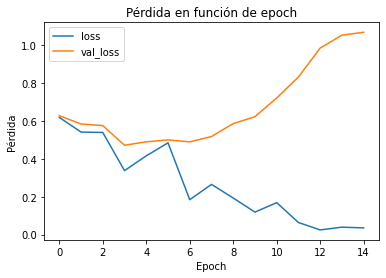

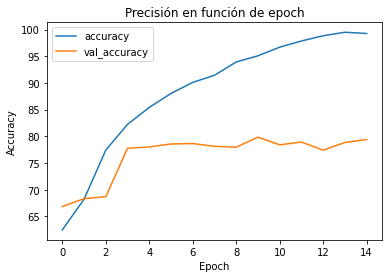

In [ ]:
plot_results(history_model_2_layers_bidi)

De nuevo, encontramos los ya habituales mínimo y máximo en la *loss function* y la precisión (respectivamente) sobre el subconjunto de validación. Así, otra vez parece que el número óptimo de *epochs* está en torno a 7. Además, se tiene *underfitting* para iteraciones tempranas (*epochs*<3) y *overfitting* cuando se entrena el modelo durante demasiadas iteraciones (*epochs*>10).

A continuación, recuperamos las predicciones sobre el *dataset* de *testing*:

In [ ]:
y_labels, y_pred_model_2_layers_bidi = test_model(model_2_layers_bidi, test_loader, train_on_gpu)

Test loss: 1.106


Si comparamos las predicciones con los valores reales:

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1250
           1       0.79      0.80      0.79      1250

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500

Confusion Matrix:


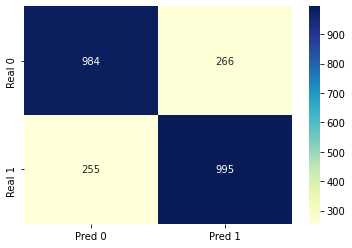

In [ ]:
print_metrics(y_labels, y_pred_model_2_layers_bidi)

En esta ocasión ambas clases están muy igualadas, siendo la precisión global:

$$ Precision_\text{total} =  \frac{TP}{TP+FN} = \frac{984+995}{984+995+255+266}=0.792$$ 

La precisión global se mantiene en valores similares a los obtenidos hasta ahora, por lo que concluimos que las mejoras añadidas no han sido significativas a la hora de mejorar la capacidad de aprendizaje de la red neuronal y vencer el *overfitting*. 

## Añadir capas de *dropout*

Como llevamos viendo en las modelizaciones realizadas hasta ahora, tenemos un problema de *overfitting* que impide que la red sea capaz de generalizar las predicciones sobre nuevas *reviews*, es decir, llega un punto en el que la red deja de "aprender" a clasificar y comienza a "memorizar" el *dataset* de entrenamiento. 

Con el objetivo de vencer este inconveniente, vamos a añadir una capa de `dropout` en el modelo. Las capas de `dropout` consisten en anular algunos de los elementos de entrada de la capa aleatoriamente, de manera que se está añadiendo una regularización y previniendo el sobreajuste durante la etapa de entrenamiento de la red.

En este caso en concreto, seleccionamos el parámetro `p=0.5`, siendo *p* la probabilidad de que un elemento se haga cero. Es decir, vamos a "apagar" aproximadamente el 50% de las neuronas.

In [ ]:
# añadimos la capa de dropout al modelo LSTM

import torch.nn as nn

embedding_size = 100
hidden_dim = embedding_size
output_dim = 1 # si fueran datos categóricos aquí iría el nº de clases
dropout = 0.5 # mitad de neuronas fuera
num_layers = 2
bidirectional = True

class LSTM(nn.Module):
  def __init__(self, vocabulary_size, embedding_size, hidden_dim,
               output_dim, num_layers, dropout, bidirectional, device):
    super(LSTM, self).__init__()

    self.output_size = output_dim
    self.hidden_dim = hidden_dim
    self.device = device

    self.embedding = nn.Embedding(vocabulary_size, embedding_size)

    self.lstm = nn.LSTM(embedding_size, hidden_dim, num_layers, 
                        dropout = dropout, batch_first=True, bidirectional = bidirectional)
    self.dropout = nn.Dropout(dropout)    
    self.fc = nn.Linear(hidden_dim * 2, output_dim)
    self.sig = nn.Sigmoid()

  def forward(self, x): 
    x = self.embedding(x)

    x = x.float()

    lstm_out, hidden = self.lstm(x)
    lstm_out = lstm_out[:, -1, :]

    out = self.dropout(lstm_out)
    out = self.fc(out)
    sig_out = self.sig(out)
    return sig_out

train_on_gpu, device = get_gpu()

# creamos el modelo de LSTM
model_2_layers_bidi_dp = LSTM(max_features + 1, embedding_size, hidden_dim,
               output_dim, num_layers, dropout, bidirectional, device=device)

# definimos learning rate, loss function y optimizer
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_2_layers_bidi_dp.parameters(), lr=lr)

print(model_2_layers_bidi_dp)

Training on GPU.
LSTM(
  (embedding): Embedding(20001, 100)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=1, bias=True)
  (sig): Sigmoid()
)


Como ya es habitual, entrenamos el nuevo modelo durante 15 *epochs*:

In [ ]:
history_model_2_layers_bidi_dp = train_model(model_2_layers_bidi_dp, criterion, optimizer, train_loader, valid_loader, train_on_gpu, 15)

Epoch: 1/15...Step: 200... Loss: 0.5562... Val Loss: 0.6045 Acc: 59.6% Val Acc: 69.4%
Epoch: 2/15...Step: 400... Loss: 0.6424... Val Loss: 0.5671 Acc: 71.0% Val Acc: 72.8%
Epoch: 3/15...Step: 600... Loss: 0.4263... Val Loss: 0.5242 Acc: 76.5% Val Acc: 76.1%
Epoch: 4/15...Step: 800... Loss: 0.5045... Val Loss: 0.5112 Acc: 81.2% Val Acc: 76.5%
Epoch: 5/15...Step: 1000... Loss: 0.3865... Val Loss: 0.4849 Acc: 85.3% Val Acc: 77.7%
Epoch: 6/15...Step: 1200... Loss: 0.3072... Val Loss: 0.4793 Acc: 88.0% Val Acc: 79.4%
Epoch: 7/15...Step: 1400... Loss: 0.2278... Val Loss: 0.5114 Acc: 90.6% Val Acc: 81.0%
Epoch: 8/15...Step: 1600... Loss: 0.4370... Val Loss: 0.5471 Acc: 92.2% Val Acc: 80.4%
Epoch: 9/15...Step: 1800... Loss: 0.2241... Val Loss: 0.5952 Acc: 93.9% Val Acc: 80.4%
Epoch: 10/15...Step: 2000... Loss: 0.1760... Val Loss: 0.6513 Acc: 94.4% Val Acc: 80.8%
Epoch: 11/15...Step: 2200... Loss: 0.1125... Val Loss: 0.7243 Acc: 96.0% Val Acc: 79.4%
Epoch: 12/15...Step: 2400... Loss: 0.0871... 

Si nos fijamos en el avance de la precisión durante el entrenamiento, vemos que esta no ha llegado al 99% como en anteriores modelizaciones, sino que es del 98.1%. Este hecho puede estar causado por la capa de *dropout* que hemos añadido, pero aun así sigue siendo una precisión muy alta sobre el subconjunto de entrenamiento, por lo que no parece que hayamos conseguido deshacernos del *overfitting*.

Para asegurarnos, representamos la evolución de la precisión y la función de pérdida durante el entrenamiento para ambos subconjuntos de datos (entrenamiento y validación):

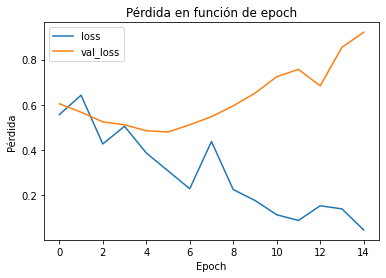

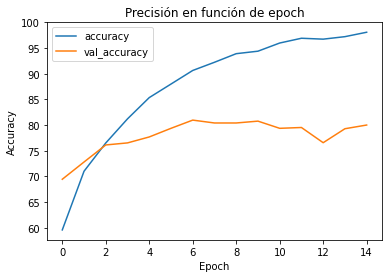

In [ ]:
plot_results(history_model_2_layers_bidi_dp)

Comprobamos que no hay una gran diferencia con respecto a los resultados obtenidos en los apartados previos, pues seguimos viendo un máximo en la precisión sobre el subconjunto de *test* en torno a 7 *epochs*, tras el cual el valor disminuye. Por consiguiente, no hemos conseguido evitar el *overfitting* añadiendo la capa de *dropout*.

Vamos a recuperar las predicciones que arroja este modelo:

In [ ]:
y_labels, y_pred_model_2_layers_bidi_dp = test_model(model_2_layers_bidi_dp, test_loader, train_on_gpu)

Test loss: 1.034


Por último, representamos la matriz de confusión y el *classification report*:

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.78      1250
           1       0.80      0.74      0.77      1250

    accuracy                           0.78      2500
   macro avg       0.78      0.78      0.78      2500
weighted avg       0.78      0.78      0.78      2500

Confusion Matrix:


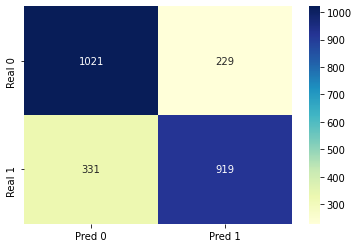

In [ ]:
print_metrics(y_labels, y_pred_model_2_layers_bidi_dp)

Comprobamos que en este caso la clase 0 tiene un mayor número de verdaderos positivos que la clase 1, esto es, las críticas negativas se están clasificando ligeramente mejor que las positivas. Así, el *recall* de la clase 1 es relativamente bajo (74%), lo cual implica que hay bastantes críticas positivas que se están clasificando como negativas.

La precisión global de este modelo sobre el subconjunto de *testing* es:

$$ Precision_\text{total} =  \frac{TP}{TP+FN} = \frac{1021+919}{1021+919+331+229}=0.776$$ 

Por lo que es la precisión más baja que hemos obtenido hasta ahora: un 1% inferior a la alcanzada en el modelo simple o *baseline*. Este hecho parece indicar que añadir la capa de *dropout* ha sido contraproducente, pues no hemos conseguido que el algoritmo sea capaz de mejorar su capacidad de aprendizaje y posterior clasificación. Como alternativa, podríamos tratar de añadir más capas de este tipo o con porcentajes diferentes para ver si de esa forma se consigue contrarrestar el *overfitting*.

## Añadir otro nivel `Linear`

A continuación, vamos a incorporar a la red neuronal una nueva capa `Linear` (*fully connected layer*), la cual esperamos que permita alcanzar más complejidad al modelo de la red neuronal y, por tanto, aumentar su precisión global sobre el subconjunto de prueba.

Las dos capas de tipo `Linear` se hallan la una tras la otra, de manera que la primera de ellas tiene una dimensión de entrada de 200 y una dimensión de salida de 50; mientras que la segunda tiene una dimensión de entrada de 50 y una salida de 1. También se ha añadido una segunda capa `dropout` similar a la ya existente.


In [ ]:
# definimos clase para el modelo de LSTMs en pytorch

import torch.nn as nn


embedding_size = 100
hidden_dim = embedding_size
hidden2_dim = int(embedding_size/2)
output_dim = 1 # si fueran datos categóricos (necesario cuando hay más de 2 clases), aquí iría el nº de clases
num_layers = 2
bidirectional = True
dropout = 0.5

class LSTM(nn.Module):
  def __init__(self, vocabulary_size, embedding_size, hidden_dim, hidden2_dim,
               output_dim, num_layers, dropout, bidirectional, device):
    super(LSTM, self).__init__()

    self.output_size = output_dim
    self.hidden_dim = hidden_dim
    self.hidden2_dim = hidden2_dim
    self.device = device

    self.embedding = nn.Embedding(vocabulary_size, embedding_size)

    self.lstm = nn.LSTM(embedding_size, hidden_dim, num_layers, dropout = dropout, batch_first=True, bidirectional = bidirectional)
    self.dropout = nn.Dropout(dropout)
    self.fc1 = nn.Linear(hidden_dim * 2, hidden2_dim)
    self.fc2 = nn.Linear(hidden2_dim, output_dim)
    self.sig = nn.Sigmoid()

  def forward(self, x): 
    x = self.embedding(x)

    x = x.float()

    lstm_out, (hidden, _) = self.lstm(x)
    out = torch.cat([hidden[-2,:,:],hidden[-1,:,:]], dim=1)

    out = self.dropout(out)
    out = self.fc1(out)
    out = self.dropout(out)
    out = self.fc2(out)
    sig_out = self.sig(out)
    return sig_out


train_on_gpu, device = get_gpu()

# creamos el modelo de LSTM
model_2_layers_bidi_dp_2fc = LSTM(max_features + 1, embedding_size, hidden_dim, hidden2_dim,
               output_dim, num_layers, dropout, bidirectional, device=device)

# definimos learning rate, loss function y optimizer
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_2_layers_bidi_dp_2fc.parameters(), lr=lr)

print(model_2_layers_bidi_dp_2fc)

Training on GPU.
LSTM(
  (embedding): Embedding(20001, 100)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=200, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (sig): Sigmoid()
)


Una vez definida la red, vamos a proceder a entrenarla durante 15 *epochs*:

In [ ]:
history_model_2_layers_bidi_dp_2fc = train_model(model_2_layers_bidi_dp_2fc, criterion, optimizer, train_loader, valid_loader, train_on_gpu, 15)

Epoch: 1/15...Step: 200... Loss: 0.6836... Val Loss: 0.6578 Acc: 57.5% Val Acc: 62.0%
Epoch: 2/15...Step: 400... Loss: 0.4384... Val Loss: 0.5652 Acc: 70.1% Val Acc: 72.0%
Epoch: 3/15...Step: 600... Loss: 0.4896... Val Loss: 0.5067 Acc: 79.0% Val Acc: 75.6%
Epoch: 4/15...Step: 800... Loss: 0.3918... Val Loss: 0.4658 Acc: 84.2% Val Acc: 79.1%
Epoch: 5/15...Step: 1000... Loss: 0.3837... Val Loss: 0.4704 Acc: 87.2% Val Acc: 78.1%
Epoch: 6/15...Step: 1200... Loss: 0.3182... Val Loss: 0.5523 Acc: 90.0% Val Acc: 79.5%
Epoch: 7/15...Step: 1400... Loss: 0.1452... Val Loss: 0.5089 Acc: 92.2% Val Acc: 79.8%
Epoch: 8/15...Step: 1600... Loss: 0.2190... Val Loss: 0.5337 Acc: 94.0% Val Acc: 78.4%
Epoch: 9/15...Step: 1800... Loss: 0.1340... Val Loss: 0.6904 Acc: 95.5% Val Acc: 77.7%
Epoch: 10/15...Step: 2000... Loss: 0.0645... Val Loss: 0.7869 Acc: 96.8% Val Acc: 80.2%
Epoch: 11/15...Step: 2200... Loss: 0.1053... Val Loss: 1.0039 Acc: 98.0% Val Acc: 79.2%
Epoch: 12/15...Step: 2400... Loss: 0.0133... 

Ahora ya podemos representar el comportamiento de la función de pérdida y la precisión total a lo largo de las 15 iteraciones:

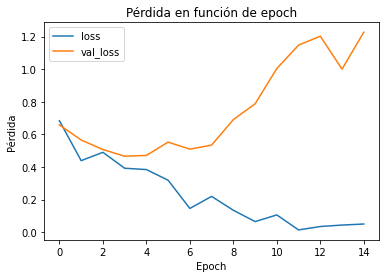

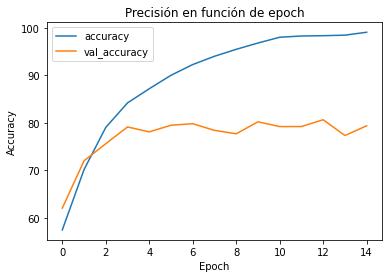

In [ ]:
plot_results(history_model_2_layers_bidi_dp_2fc)

En esta ocasión, vemos cómo el "valle" en la función de pérdida del *dataset* de validación es más pronunciado que en modelos anteriores, alcanzándose un valor superior para la pérdida al finalizar las 15 iteraciones. 

Asimismo, el máximo de la precisión sobre el subconjunto de validación se alcanza antes de las 7 *epochs* que veníamos obteniendo, en torno a unas 5 iteraciones. Por tanto, estamos alcanzando mucho antes el *overfitting*, hecho que se debe a que la red ahora es más compleja y tiene mayor capacidad de aprendizaje (tras haber añadido la segunda capa `Linear`). Así, salimos antes de la región de *underfitting* que se tiene para pocas *epochs*, necesitando menos iteraciones para "aprender" a clasificar el *dataset*. A partir de unas 5 *epochs*, estaríamos dentro de la zona de *overfitting*.

Procedemos a recuperar las predicciones para este nuevo modelo sobre el *dataset* de *testing*:

In [ ]:
y_labels, y_pred_model_2_layers_bidi_dp_2fc = test_model(model_2_layers_bidi_dp_2fc, test_loader, train_on_gpu)

Test loss: 1.337


Si analizamos los resultados, fijándonos en la matriz de confusión y el *classification report*:

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1250
           1       0.78      0.79      0.78      1250

    accuracy                           0.78      2500
   macro avg       0.78      0.78      0.78      2500
weighted avg       0.78      0.78      0.78      2500

Confusion Matrix:


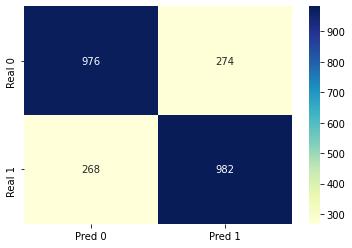

In [ ]:
print_metrics(y_labels, y_pred_model_2_layers_bidi_dp_2fc)

En esta modelización, obtenemos unos resultados muy similares entre clases, lo que implica que la red está clasificando de manera similar tanto las críticas positivas como las negativas. Tanto los valores del *precision* como del *recall* están muy equilibrados para ambas clases.

La precisión global de este modelo sobre el subconjunto de *testing* es:

$$ Precision_\text{total} =  \frac{TP}{TP+FN} = \frac{976+982}{976+982+274+268}=0.783$$ 

En consecuencia, hemos conseguido mejorar un 0.5% la precisión con respecto al modelo anterior al añadir la nueva capa lineal. No parece una mejora muy significativa si consideramos el coste de optimizar los nuevos parámetros introducidos. Por tanto, concluimos que añadir una nueva capa lineal a la red no es la elección más idónea si buscamos mejorar la *accuracy*.

## Sustituir pesos de *embeddings* por *GloVe*

La última mejora que proponemos a la red neuronal es valernos del fichero *GloVe* previamente importado. De esta forma, no inicializaremos la capa de *embeddings* de forma aleatoria. En su lugar, usaremos la matriz de *embeddings* construida anteriormente a partir del fichero *GloVe*. 

Como ya hemos argumentado, esto proporcionará a nuestro modelo una base de conocimiento previa sobre el lenguaje, donde las distancias entre los vectores que representan las palabras guardarán una mejor relación con su significado y su ámbito léxico. 

Para ello, creamos una capa de *embeddings* con los pesos de nuestra matriz de *embeddings* y congelamos su aprendizaje.


In [ ]:
# definimos clase para el modelo de LSTMs en pytorch

import torch.nn as nn

embedding_size = 100
hidden_dim = embedding_size
hidden2_dim = int(embedding_size/2)
output_dim = 1 # si fueran datos categóricos (necesario cuando hay más de 2 clases), aquí iría el nº de clases
dropout = 0.5
num_layers = 2
bidirectional = True

class LSTM(nn.Module):
  def __init__(self, vocabulary_size, embedding_size, hidden_dim, hidden2_dim,
               output_dim, num_layers, dropout, bidirectional, device):
    super(LSTM, self).__init__()

    self.output_size = output_dim
    self.hidden_dim = hidden_dim
    self.hidden2_dim = hidden2_dim
    self.device = device

    self.embedding = nn.Embedding(vocabulary_size, embedding_size, padding_idx=0)
    self.embedding.weight.data.copy_((embedding_matrix))
    self.embedding.weight.requires_grad = False ## freeze embeddings

    self.lstm = nn.LSTM(embedding_size, hidden_dim, num_layers, dropout = dropout, batch_first=True, bidirectional = bidirectional)
    self.dropout = nn.Dropout(dropout)
    self.fc1 = nn.Linear(hidden_dim * 2, hidden2_dim)
    self.fc2 = nn.Linear(hidden2_dim, output_dim)
    self.sig = nn.Sigmoid()

  def forward(self, x): 
    x = self.embedding(x)

    x = x.float()

    lstm_out, (hidden, _) = self.lstm(x)
    out = torch.cat([hidden[-2,:,:],hidden[-1,:,:]], dim=1)

    out = self.dropout(out)
    out = self.fc1(out)
    out = self.dropout(out)
    out = self.fc2(out)
    sig_out = self.sig(out)
    return sig_out

train_on_gpu, device = get_gpu()

# creamos el modelo de LSTM
model_2_layers_bidi_dp_2fc_embeddings = LSTM(max_features + 1, embedding_size, hidden_dim, hidden2_dim,
               output_dim, num_layers, dropout, bidirectional, device=device)

# definimos learning rate, loss function y optimizer
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_2_layers_bidi_dp_2fc_embeddings.parameters(), lr=lr)

#Hacemos la sustitución de pesos:
#model.embedding.weight.data = embedding_matrix

print(model_2_layers_bidi_dp_2fc_embeddings)

Training on GPU.
LSTM(
  (embedding): Embedding(20001, 100, padding_idx=0)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=200, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (sig): Sigmoid()
)


Una vez definida la nueva red, procedemos a entrenarla durante 15 *epochs*:

In [ ]:
history_model_2_layers_bidi_dp_2fc_embeddings = train_model(model_2_layers_bidi_dp_2fc_embeddings, criterion, optimizer, train_loader, valid_loader, train_on_gpu, 15)

Epoch: 1/15...Step: 200... Loss: 0.5731... Val Loss: 0.5797 Acc: 63.0% Val Acc: 69.9%
Epoch: 2/15...Step: 400... Loss: 0.5758... Val Loss: 0.5398 Acc: 73.3% Val Acc: 73.1%
Epoch: 3/15...Step: 600... Loss: 0.4919... Val Loss: 0.4797 Acc: 77.2% Val Acc: 76.6%
Epoch: 4/15...Step: 800... Loss: 0.5124... Val Loss: 0.4447 Acc: 80.0% Val Acc: 80.1%
Epoch: 5/15...Step: 1000... Loss: 0.3317... Val Loss: 0.4078 Acc: 82.2% Val Acc: 82.2%
Epoch: 6/15...Step: 1200... Loss: 0.3510... Val Loss: 0.3843 Acc: 84.1% Val Acc: 82.4%
Epoch: 7/15...Step: 1400... Loss: 0.2985... Val Loss: 0.4286 Acc: 84.9% Val Acc: 81.9%
Epoch: 8/15...Step: 1600... Loss: 0.3733... Val Loss: 0.3725 Acc: 85.5% Val Acc: 83.7%
Epoch: 9/15...Step: 1800... Loss: 0.4382... Val Loss: 0.3708 Acc: 86.2% Val Acc: 84.2%
Epoch: 10/15...Step: 2000... Loss: 0.3998... Val Loss: 0.3884 Acc: 86.7% Val Acc: 83.3%
Epoch: 11/15...Step: 2200... Loss: 0.1761... Val Loss: 0.3938 Acc: 87.5% Val Acc: 84.2%
Epoch: 12/15...Step: 2400... Loss: 0.2761... 

Observamos una gran diferencia con respecto a las modelizaciones previas puesto que, si nos fijamos en la *loss function* para el subconjunto de entrenamiento, vemos que el descenso no es monótono sino que oscila mucho. Por su parte, la precisión sobre el subconjunto de *training* se ha quedado en aproximadamente un 90%, bastante lejos del 99% que veníamos obteniendo en modelizaciones previas.

Para visualizar mejor la evolución, representamos la función de pérdida y la *accuracy* en función de las etapas de entrenamiento:

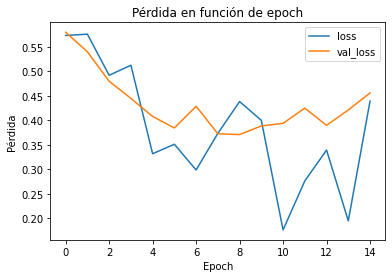

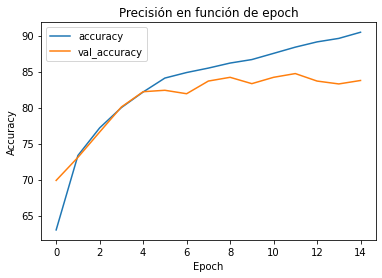

In [ ]:
plot_results(history_model_2_layers_bidi_dp_2fc_embeddings)

Como ya habíamos previsto, las gráficas son muy dispares a las representadas para las modelizaciones previas. En concreto, vemos cómo la función de pérdida tiene un comportamiento muy oscilatorio para el subconjunto de entrenamiento. 

La precisión sobre dicho *dataset* es monótona ascendente con el número de *epochs*. Además, la evolución es muy similar a la del *dataset* de validación hasta aproximadamente 5 iteraciones. A partir de ahí, la precisión sobre el subconjunto de *training* sigue subiendo mientras que la precisión sobre el subconjunto de validación comienza a oscilar. En resumen, para *epochs*<3 se tiene *underfitting*, mientras que para aproximadamente *epochs*>10 existe *overfitting*. Es decir, hemos conseguido "retrasar" la aparición del *overfitting* con respecto a los algoritmos previos. Esto se debe al uso de la matriz de *embeddings* de *GloVe*, la cual ha permitido incrementar la capacidad de aprendizaje de la red y aumentar la precisión de las predicciones del modelo.

Si almacenamos las predicciones sobre el subconjunto de *testing*:

In [ ]:
y_labels, y_pred_model_2_layers_bidi_dp_2fc_embeddings = test_model(model_2_layers_bidi_dp_2fc_embeddings, test_loader, train_on_gpu)

Test loss: 0.493


Podemos representar tanto la matriz de confusión como el *classification report*:

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1250
           1       0.80      0.90      0.84      1250

    accuracy                           0.83      2500
   macro avg       0.84      0.83      0.83      2500
weighted avg       0.84      0.83      0.83      2500

Confusion Matrix:


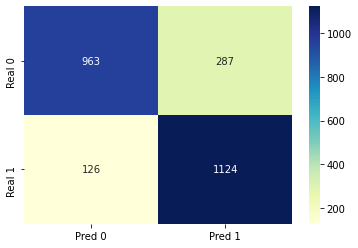

In [ ]:
print_metrics(y_labels, y_pred_model_2_layers_bidi_dp_2fc_embeddings)

En la matriz se ve cómo existen más verdaderos positivos para la clase 1, esto es, las críticas positivas están clasificándose mejor por el algoritmo. 

Si nos fijamos en los valores del *precision* y el *recall*, todos ellos son bastante altos en comparación con los resultados que habíamos alcanzado con las mejoras propuestas hasta ahora. En concreto, destaca el *recall* del 90% para la categoría 1, lo cual indica que el 90% de las críticas positivas se están etiquetando correctamente. Este porcentaje disminuye en el caso de las críticas negativas, es decir, un 77% de las *reviews* de este tipo se están clasificando como tal. En contraposición, la clase 0 tiene un valor alto para la *precision*, esto es, de todas las veces que el algoritmo ha clasificado una *review* como negativa, ha acertado el 88% de ellas. El porcentaje disminuye al 80% en el caso de las críticas clasificadas como positivas.

La precisión global de este modelo sobre el subconjunto de *testing* es:

$$ Precision_\text{total} =  \frac{TP}{TP+FN} = \frac{963+1124}{963+1124+287+126}=0.835$$ 

Por tanto, con la modificación del *embedding*, se ha mejorado más de un 5% la precisión global de las predicciones sobre el subconjunto de prueba con respecto al modelizado anterior y con respecto al *baseline* también. Es, con diferencia y como cabía esperar, la mejora más significativa introducida en el modelo hasta ahora.


# 6. Conclusiones

A lo largo de esta tarea, nos hemos propuesto analizar el sentimiento de críticas o *reviews* de películas extraídas de la plataforma IMDB mediante una arquitectura de red neuronal tipo LSTM. En total, se ha trabajado con 25.000 opiniones, la mitad de las cuales tenían un sentimiento positivo y la otra mitad, uno negativo. Así, se ha dividido el *dataset* en un 80% para el entrenamiento, un 10% para la validación y el 10% restante para el *testing*. 

En primer lugar hemos procedido a preprocesar el *dataset*, realizando las alteraciones necesarias para poder alimentar la red neuronal. Las principales acciones llevadas a cabo han consistido en:

1. Eliminación de mayúsculas y signos no alfanuméricos.
2. Tokenización o separación de las *reviews* en palabras.
3. Indexado de las palabras.
4. Homogeneización de la longitud de cada *review*.
5. Separación en tres subconjuntos.

A continuación, se ha definido la red neuronal LSTM junto con diversas funciones que llevan a cabo el entrenamiento y la evaluación del modelo. Una vez se ha tenido el modelo más básico listo, al cual hemos denominado *modelo baseline*, se ha ejecutado el entrenamiento durante 15 iteraciones sobre el subconjunto de entrenamiento.  Finalmente, la precisión global alcanzada ha sido del 78.6% sobre el subconjunto de prueba. También se ha observado la presencia de *overfitting* al avanzar el entrenamiento.

Con el objetivo de mejorar la precisión del clasificador de *reviews* que hemos generado, se han propuesto una serie de mejoras a la red neuronal, en concreto:

- Adición de profundidad mediante un segundo nivel LSTM.
- Adición de bidireccionalidad.
- Disminución de *overfitting* mediante la adición de una capa *dropout*.
- Adición de profundidad mediante una segunda capa lineal.
- Sustitución de los pesos de *embeddings* por los de un fichero *GloVe* cuyos vectores son de dimensión 100.

En la siguiente tabla se resumen los resultados obtenidos para cada modelización, teniendo en cuenta que cada mejora se ha añadido sobre la mejora previa:

|   Modelo                  | *Test accuracy*    | 
|---------------------------|:------------------:|
|   Simple o *baseline*     |       78.6%        |
|   Segunda capa LSTM       |       79.6%        |
|   Bidireccionalidad       |       79.2%       |
|   *Dropout*               |       77.6%       |
|   Segunda capa `Linear`   |       78.3%       |
|   *Embeddings (GloVe)*    |       83.5%       |


Como se puede comprobar, la sustitución de los pesos por los del fichero *GloVe* ha representado la mayor mejora con mucha diferencia. Esto es debido a que la matriz de *embeddings* obtenida a partir del fichero proporciona información de cómo estructurar las palabras según su significado o ámbito léxico. De esta forma, se facilita la comprensión por parte de la red de la relación que existe entre las palabras, como por ejemplo los sinónimos. Además, debido a que los pesos están congelados, la cantidad de parámetros a ajustar es menor, reduciendo, como hemos visto anteriormente, el *overfitting* de la red. El resultado final es un mejor rendimiento, con un aprendizaje más rápido y una *accuracy* más elevada.

Por contra, en el resto de modelos no partimos de ningún conocimiento del lenguaje más a allá de qué palabras son más frecuentes que otras. La capa de *embeddings* se inicializa de forma aleatoria siguiendo una distribución normal y en el proceso de aprendizaje los vectores se van ajustando. De esta forma, estos modelos están tratando de entender la estructura del lenguaje a la vez que analizan el sentimiento. Así, con un *dataset* relativamente pequeño, la red tiende más a memorizar las *reviews* de entrenamiento que a aprender el sentimiento que hay detrás. Es por este motivo que en estos modelos observamos un acusado *overfitting* comparado con el modelo *GloVe*, y por el cual añadir más complejidad al algoritmo no se traduce en una mejora apreciable (incluso a veces existe un empeoramiento).

En conclusión, la importancia de un conocimiento previo del lenguaje, como el que pueden proporcionar los *embeddings* de *GloVe*, es una pieza fundamental a la hora de alcanzar mejores rendimientos, sobre todo cuando los recursos disponibles son limitados.